In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output

import math
from scipy import integrate
import scipy.interpolate

In [37]:
class tank_:
    def __init__(self):
        self.a = 2.9 # ширина, м
        self.b = 2.2 # высота, м
        self.type = '100' # тип танковой пушки
        self.n = 15 # скорострельность, 1/м
        self.omega = 1.7 # среднее число попаданий, необходимое для поражения цели
        self.V = 12 # скорость танка, м/с
        self.Ex_x = 1/1300

class test_:
    def __init__(self):
        self.a = 2.2 # ширина, м
        self.b = 3 # высота, м
        self.type = '100' # тип танковой пушки
        self.n = 140 # скорострельность, 1/м
        self.omega = 1.3 # среднее число попаданий, необходимое для поражения цели
        self.V = 14 # скорость танка, м/с
        self.Ex_x = 1/800

class test_ATS_:
    def __init__(self):
        self.a = 1.5 # ширина, м
        self.b = 2 # высота, м
        self.type = '100' # тип танковой пушк
        self.n = {  # скорострельность
            '100': 120,
            '152': 120,
            'ПТРК': ['сам', 'ком'][0]   }
        self.omega = {  # тип танковой пушки
            '100': 1.2,
            '152': 1.1,
            'ПТРК': 1.0
        }
        self.V = 120 # скорость ПТУР, м/c
        self.Ex_x = {
            '100': 1/800,
            '152': 1/900,
            'ПТРК': 1/800
        }

class ATS_:
    def __init__(self):
        self.a = 1.8 # ширина, м
        self.b = 2 # высота, м
        self.type = ['100', '152', 'ПТРК'] # типы пушек
        self.n = {  # скорострельность
            '100': 14,
            '152': 12,
            'ПТРК': ['сам', 'ком'][0]   }
        self.omega = {  # тип танковой пушки
            '100': 1.5,
            '152': 1.2,
            'ПТРК': 1.3
        }
        self.V = 160 # скорость ПТУР, м/c
        self.Ex_x = {
            '100': 1/1500,
            '152': 1/900,
            'ПТРК': 1/1500
        }

class figth_:
    def __init__(self, tank, ATS):
        self.tank = tank
        self.ATS = ATS

    def refresh(self):
        self.x = 900
        self.t = 0
        self.table = pd.DataFrame({
            't': [],
            'X': [],
            'sigma': [],
            'Ф_b': [],
            'Ф_а': [],
            'W': [],
            'key': []     
            })
    
    def get_F(self, x):
        def f(t):
            return math.exp(-t**2/2)
        part_1 = 1/math.sqrt(2*math.pi)
        part_2, err = integrate.quad(f, 0, x)
        return part_1*part_2

    def get_W_tank(self):
         return 4/self.tank.omega*self.F_a*self.F_b
    
    def get_W_ATS(self, type_):
         return 4/self.ATS.omega[type_]*self.F_a*self.F_b
    
    def calculate_tank(self):
        self.refresh()

        while self.x > 0:

            self.sigma = 1.48*self.tank.Ex_x*self.x

            self.F_a = self.get_F(self.ATS.a/(2*self.sigma))
            self.F_b = self.get_F(self.ATS.b/(2*self.sigma))

            self.W = self.get_W_tank()
            
            tmp_df = pd.DataFrame({
                't': [self.t+0.00001],
                'X':[self.x],
                'sigma': [self.sigma],
                'Ф_b': [self.F_b],
                'Ф_а': [self.F_a],
                'W': [self.W],
                'key': ['tank']})

            self.table = pd.concat([self.table, tmp_df], ignore_index = True)

            self.t += 60/self.tank.n
            self.x -= self.tank.V*60/self.tank.n

        tmp_df = pd.DataFrame({
                't': [self.t],
                'X':[0],
                'sigma': [self.sigma],
                'Ф_b': [self.F_b],
                'Ф_а': [self.F_a],
                'W': [self.W],
                'key': ['tank']})

        self.table = pd.concat([self.table, tmp_df], ignore_index = True)

        return self.table

    def calculate_ATS(self, type_):
        self.refresh()

        while self.x > 0:
            
            self.sigma = 1.48*self.ATS.Ex_x[type_]*self.x

            self.F_a = self.get_F(self.tank.a/(2*self.sigma))
            self.F_b = self.get_F(self.tank.b/(2*self.sigma))

            self.W = self.get_W_ATS(type_)
            
            tmp_df = pd.DataFrame({
                't': [self.t],
                'X':[self.x],
                'sigma': [self.sigma],
                'Ф_b': [self.F_b],
                'Ф_а': [self.F_a],
                'W': [self.W],
                'key': ['ATS']})

            self.table = pd.concat([self.table, tmp_df], ignore_index = True)

            self.t += 60/self.ATS.n[type_]
            # print(self.ATS.V*60/self.ATS.n[type_])
            self.x -= self.tank.V*60/self.ATS.n[type_]

        tmp_df = pd.DataFrame({
                't': [self.t],
                'X':[0],
                'sigma': [self.sigma],
                'Ф_b': [self.F_b],
                'Ф_а': [self.F_a],
                'W': [self.W],
                'key': ['ATS']})

        self.table = pd.concat([self.table, tmp_df], ignore_index = True)
        
        return self.table

    def calculate_ATS_PRYR(self, type_):
        self.refresh()

        while self.x > 0:
            
            self.sigma = 1.48*self.ATS.Ex_x[type_]*self.x

            self.F_a = self.get_F(self.tank.a/(2*self.sigma))
            self.F_b = self.get_F(self.tank.b/(2*self.sigma))

            self.W = self.get_W_ATS(type_)
            
            tmp_df = pd.DataFrame({
                't': [self.t],
                'X':[self.x],
                'sigma': [self.sigma],
                'Ф_b': [self.F_b],
                'Ф_а': [self.F_a],
                'W': [self.W]  })

            self.table = pd.concat([self.table, tmp_df], ignore_index = True)

            # print(self.ATS.V*60/self.ATS.n[type_])
            self.t += self.x/(self.tank.V+self.ATS.V)
            self.x -= self.tank.V*self.t
            

        tmp_df = pd.DataFrame({
                't': [self.t],
                'X':[0],
                'sigma': [self.sigma],
                'Ф_b': [self.F_b],
                'Ф_а': [self.F_a],
                'W': [self.W]  })

        self.table = pd.concat([self.table, tmp_df], ignore_index = True)
        
        return self.table

    def probab(df_T, df_100, df_152, df_PTYR):
        table = pd.DataFrame({
            't': [],
            'X': [],
            'sigma': [],
            'Ф_b': [],
            'Ф_а': [],
            'W': []     
            })

tank = tank_()
ATS = ATS_()
test_tank = test_()
test_ATS = test_ATS_()
figth = figth_(test_tank, test_ATS)

df_tank_100 = figth.calculate_tank()
df_ATS_100 = figth.calculate_ATS('100')
df_ATS_152 = figth.calculate_ATS('152')
df_ATS_PTYR = figth.calculate_ATS_PRYR('ПТРК')

(0.0, 900.0)

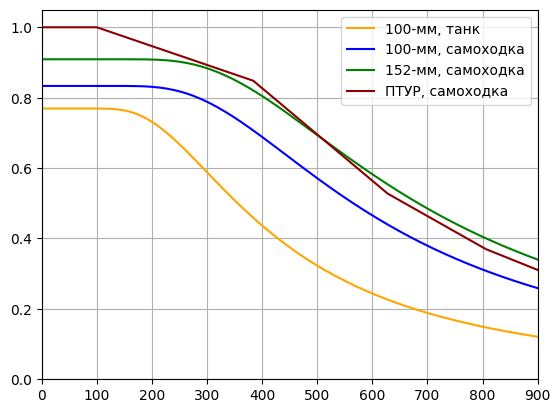

In [38]:
plt.plot(df_tank_100.X, df_tank_100.W, c='orange', label='100-мм, танк')
plt.plot(df_ATS_100.X, df_ATS_100.W, c='blue', label='100-мм, самоходка')
plt.plot(df_ATS_152.X, df_ATS_152.W, c='green', label='152-мм, самоходка')
y_interp = scipy.interpolate.interp1d(df_ATS_PTYR.X, df_ATS_PTYR.W)
plt.plot(df_ATS_PTYR.X, df_ATS_PTYR.W, c='darkred', label='ПТУР, самоходка')
plt.legend()
plt.grid()
plt.ylim(0, 1.05)
plt.xlim(0, 900)

In [39]:
df_ATS_100

,t,X,sigma,Ф_b,Ф_а,W,key
0,0.0,900.0,1.66500,0.316179,0.245585,0.258830,ATS
1,0.5,893.0,1.65205,0.318051,0.247243,0.262120,ATS
2,1.0,886.0,1.63910,0.319940,0.248922,0.265467,ATS
3,1.5,879.0,1.62615,0.321846,0.250621,0.268871,ATS
4,2.0,872.0,1.61320,0.323770,0.252341,0.272335,ATS
...,...,...,...,...,...,...,...
125,62.5,25.0,0.04625,0.500000,0.500000,0.833333,ATS
126,63.0,18.0,0.03330,0.500000,0.500000,0.833333,ATS
127,63.5,11.0,0.02035,0.500000,0.500000,0.833333,ATS
128,64.0,4.0,0.00740,0.500000,0.500000,0.833333,ATS


In [113]:
df = pd.concat([df_ATS_100, df_tank_100], ignore_index = True).sort_values('X', key=lambda x: -x)
df.tail(20)

,t,X,sigma,Ф_b,Ф_а,W,key
120,60.000000,60.0,0.11100,0.5,0.5,0.833333,ATS
271,60.428581,54.0,0.09990,0.5,0.5,0.769231,tank
121,60.500000,53.0,0.09805,0.5,0.5,0.833333,ATS
272,60.857153,48.0,0.08880,0.5,0.5,0.769231,tank
122,61.000000,46.0,0.08510,0.5,0.5,0.833333,ATS
273,61.285724,42.0,0.07770,0.5,0.5,0.769231,tank
123,61.500000,39.0,0.07215,0.5,0.5,0.833333,ATS
274,61.714296,36.0,0.06660,0.5,0.5,0.769231,tank
124,62.000000,32.0,0.05920,0.5,0.5,0.833333,ATS
275,62.142867,30.0,0.05550,0.5,0.5,0.769231,tank


In [121]:
ATS_index, tank_index, tank_index0 = 0, len(df_ATS_100), len(df_ATS_100)
df.W[tank_index]

0.12083447298514964

In [122]:
df_W_ = pd.DataFrame({
    't': [df.t[ATS_index], df.t[tank_index]],
    'W_': [df.W[ATS_index], '-'],
    'V_': ['-', (1 - df.W[ATS_index])*df.W[tank_index]],
    'key': ['ATS', 'tank']
})

ATS_index += 1
tank_index += 1

df_W_

,t,W_,V_,key
0,0.00000,0.25883,-,ATS
1,0.00001,-,0.089559,tank


In [123]:
for row in df.iterrows():
    if row[0] == len(df):
        break
    if df.t[row[0]] != 0 and df.t[row[0]] != 0.00001: 
        if df.key[row[0]] == 'ATS':

            calc = df.W[row[0]]

            for i in range(ATS_index):
                calc *= (1 - df.W[i])
            for i in range(tank_index0, tank_index):
                calc *= (1 - df.W[i])

            for row_2 in df_W_.iterrows():
                if df_W_.key[row_2[0]] == 'ATS':
                    tmp = df_W_.W_[row_2[0]]
            calc += tmp

            tmp_df = pd.DataFrame({
                't': [df.t[row[0]]],
                'W_': [calc],
                'V_': ['-'],
                'key': ['ATS']
                })
            
            ATS_index += 1

        elif df.key[row[0]] == 'tank':
            
            calc = df.W[row[0]]

            for i in range(ATS_index):
                calc *= (1 - df.W[i])
            for i in range(tank_index0, tank_index):
                calc *= (1 - df.W[i])

            for row_2 in df_W_.iterrows():
                if df_W_.key[row_2[0]] == 'tank':
                    tmp = df_W_.V_[row_2[0]]
            calc += tmp

            tmp_df = pd.DataFrame({
                't': [df.t[row[0]]],
                'W_': ['-'],
                'V_': [calc],
                'key': ['tank']
                })
            
            tank_index += 1

        df_W_ = pd.concat([df_W_, tmp_df], ignore_index = True)
        #print(df.W[row[0]], df.key[row[0]])
    df_W_

In [125]:
df_W_

,t,W_,V_,key
0,0.000000,0.25883,-,ATS
1,0.000010,-,0.089559,tank
2,0.428581,-,0.16926,tank
3,0.500000,0.408739,-,ATS
4,0.857153,-,0.221511,tank
...,...,...,...,...
276,63.500000,0.679717,-,ATS
277,63.857153,-,0.320283,tank
278,64.000000,0.679717,-,ATS
279,64.500000,0.679717,-,ATS


In [126]:
df_W_.W_ != '-'

0       True
1      False
2      False
3       True
4      False
       ...  
276     True
277    False
278     True
279     True
280    False
Name: W_, Length: 281, dtype: bool

In [76]:
plt.plot(df_W_.X, df_tank_100.W, c='orange', label='100-мм, танк')

plt.legend()
plt.grid()

,W_,V_
0,0.25883,0.089559


In [67]:

print(ar)
for row in df.iterrows():
    if df.key[row[0]] == 'ATS':
        pass
    elif df.key[row[0]] == 'tank':
        pass
    print(df.W[row[0]], df.key[row[0]])
    ar.append()

[0.2588298257095675, 0.08955890740269593]
0.2588298257095675 ATS
0.12083447298514964 tank
0.1223132340623159 tank
0.26211980191902073 ATS
0.12381827354988355 tank
0.2654665512369994 ATS
0.12535018881521953 tank
0.2688711769156723 ATS
0.12690959324664633 tank
0.27233479964923946 ATS
0.12849711672415298 tank
0.27585855730596864 ATS
0.1301134061036429 tank
0.279443604597372 ATS
0.13175912571497403 tank
0.13343495787403825 tank
0.28309111267855414 ATS
0.13514160340910972 tank
0.28680226867326974 ATS
0.13687978220167393 tank
0.29057827511672385 ATS
0.13865023374192986 tank
0.29442034930858585 ATS
0.14045371769912957 tank
0.2983297225681028 ATS
0.1422910145068938 tank
0.14416292596360689 tank
0.30230763938255917 ATS
0.14607027584795437 tank
0.3063553564396554 ATS
0.14801391054962623 tank
0.31047414153364916 ATS
0.14999469971515386 tank
0.3146652723343374 ATS
0.15201353690879424 tank
0.31893003500712563 ATS
0.15407134028830763 tank
0.3232697226715623 ATS
0.15616905329540304 tank
0.15830764536

In [29]:
def crit(c_cn, ):
    C_CAY = 10000
    C_snar = {
        '100': 100,
        '152': 300,
        'ПТУР': 600
    }
    N_bk = {
        '100': 40,
        '152': 30,
        'танк': 40
    }
    pass

